# Introduction
For this final phase we will solve the inverse problem $A = W^{-1}\cdot M$ and recover the perturbation position. Nevertheless, we will add some noise to our measurement detectors for a more realistic approach on the problem. Then this phase is going to be composed by the noise definition of our problem, a regularization procedure to dimish the noise contribution and finally the solution of the inverse linear problem with a 3D reconstruction of the perturbation position.

## Initialization

To make our procedure more clear we pre define all the main variables and parameters to have a more modular programming scheme. 

In [249]:
# Libraries
import numpy as np                       #Numpy library python
from numpy import linalg as LA           #Linear algebra functions python
import matplotlib.pyplot as plt          #Plot library functions python
from mpl_toolkits.mplot3d import Axes3D  #3D plot library functions python
from ipywidgets import interactive       #Dynamic plots library python
#--------------------------------------------------------------------------
#General parameters definition
#--------------------------------------------------------------------------
voxel_step = 8                      #Division of space in voxels
Nvox_dim = int(64/voxel_step)       #Number of voxels per axis
Nvox = Nvox_dim**3                  #Number of Voxels representing the space
dmu_a = 0.1                         #Absorption perturbation [cm^-1]
t = np.linspace(0.03, 8, 9)*10**-9  # Time [s]
ma_0 = 0.1                          # Absorption coeff. [cm^-1]
ms_p = 10                           # Scattering coeff. [cm^-1]
D = 1/(3*ms_p)                      # Diffusion coeff.
c = 3*10**10
# Voxels index for perturbation position first element 10 cm depth, 2nd = 20 cm depth, 3rd = 30cm depth
pert_indxs = [2+Nvox_dim*2+6*Nvox_dim**2,2+Nvox_dim*2+5*Nvox_dim**2,2+Nvox_dim*2+4*Nvox_dim**2] 

## Functions

In [250]:
#---------------------------------------------------------------
# Matrix A construction
#---------------------------------------------------------------
#Function that constructs the A matrix
def matrixA (Nvox,dmu_a,pert_indx):
    A = np.zeros(Nvox) 
    A[pert_indx] = dmu_a
    return A
Atest = matrixA(Nvox,dmu_a,pert_indxs[1])#Set the perturbation position we want to have, index 0 (10 cm depth), 1 (20 cm depth), 2 (30 cm depth)
#---------------------------------------------------------------
# Matrix M construction
#---------------------------------------------------------------
# Function for M construction
def matrixM (t,Nvox_dim,D,dma,pert_pos):
    SD_pairs = int(Nvox_dim*Nvox_dim)         # Number of S-D pairs
    m_indx = int(SD_pairs*len(t))             # Index of time gates counted for the S-D pairs
    rvox = np.zeros(SD_pairs)                 # Vector compressed for position from S-D pair to perturbation (64x1)
    M = np.zeros(m_indx)                      # Matrix of measurements with compressed indexes (576x1)
    xvoxs = 2-np.linspace(.4,6.0,Nvox_dim)  # Coord. in x for the vector from S-D pairs to the perturbation
    yvoxs = 2-np.linspace(.4,6.0,Nvox_dim)  # Coord. in y for the vector from S-D pairs to the perturbation
    zvoxs = [6.4-1.2,6.4-2,6.4-2.8]         # Coord. in z for the vector from S-D pairs to the perturbation
    for i in range(len(xvoxs)):
        for j in range(len(yvoxs)):
            i_p = i +j*Nvox_dim               # Index compression
            rvox[i_p] = np.sqrt(xvoxs[i]**2+yvoxs[j]**2+zvoxs[pert_pos]**2) 
    # Calculation of M through the relative contrast
    for k in range(len(t)):
        for l in range(len(rvox)):
            kcount = l + k*len(rvox)
            c = 3*10**10
            M[kcount] = 1/(4*np.pi*D)*dma*(2/rvox[l])*np.exp(-rvox[l]**2/(c*D*t[k]))
    return (1-M) # (phi-deltaphi)/phi = 1 - deltaphi/phi
#----------------------------------------------------------------
# Matrix W construction (576x512)
#----------------------------------------------------------------
def matrixW(t,Nvox_dim,D,c):
    SD_pairs = int(Nvox_dim*Nvox_dim)         # Number of S-D pairs
    m_indx = int(SD_pairs*len(t))             # Index of time gates counted for the S-D pairs
    rvox = np.zeros((SD_pairs,Nvox))          # Vector compressed for position from S-D pair to perturbation
    W = np.zeros((m_indx,Nvox))               # Sensitivity Matrix with compressed indexes (576x512)
    x_SD = np.linspace(.4,6.0,Nvox_dim)       # Coord. in x for the vector from S-D pairs 
    y_SD = np.linspace(.4,6.0,Nvox_dim)       # Coord. in y for the vector from S-D pairs 
    z_SD = 6.4
    xvox = np.linspace(.4,6.0,Nvox_dim)       # Voxels range in x direction
    yvox = np.linspace(.4,6.0,Nvox_dim)
    zvox = np.linspace(.4,6.0,Nvox_dim)

    # Index compression for the distance between the S-D pairs to the perturbation
    for j in range(len(y_SD)):
        for i in range(len(x_SD)):
            for l in range(len(zvox)):
                for n in range(len(xvox)):
                    for m in range(len(yvox)):
                        n_p = i + j*Nvox_dim
                        m_p = m + Nvox_dim*(n + l*Nvox_dim)            # Index compression for voxels
                        rvox[n_p,m_p] = np.sqrt((x_SD[i]-xvox[n])**2+(y_SD[j]-yvox[m])**2+(z_SD-zvox[l])**2) 
    # Creation of the W matrix
    i_c = 0
    for k in range(len(t)):
        for i in range(SD_pairs):
            for j in range(Nvox):
                W[i_c,j] = 1/(4*np.pi*D)*(2/rvox[i,j])*np.exp(-rvox[i,j]**2/(c*D*t[k]))
            i_c = i_c+1
    return W
#------------------------------------------------------------------------
#Contour plots construction function for M matrix (function for interactive plots, only on Jupyter notebooks)
#------------------------------------------------------------------------
def plotting1(gate,pert_pos):
    M_cont = np.zeros((Nvox_dim,Nvox_dim))    # Matrix for contour plot 
    M = matrixM (t,Nvox_dim,D,dmu_a,pert_pos)
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        M_cont[:Nvox_dim,j] = M[counter:counter+Nvox_dim]
        counter = counter + Nvox_dim
        j = j+1
    plt.contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),np.transpose(M_cont))
    plt.colorbar()
#----------------------------------------------------------------------
#Contour plots construction function for M matrix with W (function for interactive plots, only on Jupyter notebooks)
#----------------------------------------------------------------------
def plotting2(gate):
    W =  matrixW(t,Nvox_dim,D,c)
    M_cont = np.zeros((Nvox_dim,Nvox_dim))    # Matrix for contour plot (8x8x8)
    #Mtest = np.zeros(m_indx)
    Mtest = np.matmul(W,Atest)
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        M_cont[:Nvox_dim,j] = Mtest[counter:counter+Nvox_dim]
        counter = counter + Nvox_dim
        j = j+1
    plt.contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),M_cont)
    plt.colorbar()
#-----------------------------------------------------------------------
#Contour plots construction function for M matrix with noise (function for interactive plots, only on Jupyter notebooks)
#-----------------------------------------------------------------------
def plotting1_noise(gate,pert_pos,Nexp):
    M_cont = np.zeros((Nvox_dim,Nvox_dim))    # Matrix for contour plot 
    M = matrixM (t,Nvox_dim,D,dmu_a,pert_pos)
    N =10**Nexp
    Mnoise = -(np.random.poisson(N-N*M)-np.random.poisson(N))/np.random.poisson(N)
    #Mnoise =(np.random.poisson(N*M))/N
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        M_cont[:Nvox_dim,j] = Mnoise[counter:counter+Nvox_dim]
        counter = counter + Nvox_dim
        j = j+1
    plt.contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),np.transpose(M_cont))
    plt.colorbar()
#-----------------------------------------------------------------------
#Contour plots construction function for M matrix with noise (function for interactive plots, only on Jupyter notebooks)
#-----------------------------------------------------------------------
def plotting2_noisy(gate):
    M_cont = np.zeros((Nvox_dim,Nvox_dim))    # Matrix for contour plot (8x8x8)
    Mtest = Wnew@Asol
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        M_cont[:Nvox_dim,j] = Mtest[counter:counter+Nvox_dim]
        counter = counter + Nvox_dim
        j = j+1
    plt.contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),M_cont)
    plt.colorbar()

# Poisson Noise definition

For this phase we will assume that our detectors are not ideal and therefore Poisson noise on the photodetection must be considered. Poisson noise is caracterized by its random nature, related in a classical picture to the so called Shot noise. It can be characterized by a Poisson distribution whose must used parameters are the mean and the variance, the mean of the Poisson distribution is the peak of the distribution and its variance is characterized by the average value of the distribution. For our problem we will assume that each Detector is susceptible to shot noise and in average detects $N = 10^{6}$ photon counts for measurement, this means it is the total number of photons detected. 

Before we go forward, first we will show how the inverse problem looks without noise effects and then we will see the behaviour of our problem by adding the noise. 

## Inverse problem without noise
 To solve our problem, we use the pseudo inverse of matrix W to calculate the perturbation position, for simplicity we will just show the index of the perturbation and compare by eye that it corresponds to the correct one. 

(array([338]),)

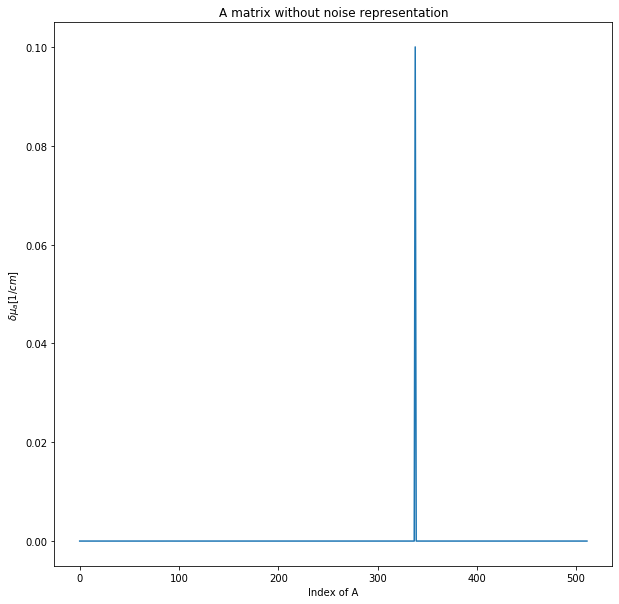

In [251]:
W = matrixW(t,Nvox_dim,D,c) #Define our W matrix
Mtest2 = W@Atest            #Define our M matrix with perturbation position at 20 mm depth (arbitrary parameter just for testing)
Ainv = LA.pinv(W)@Mtest2    #Solution of the inverse problem without noise using the command for pseudoinverse
plt.plot(np.arange(0,512,1),Ainv)
#Labels
plt.xlabel('Index of A')
plt.ylabel('$\delta \mu_{a} [1/cm]$')
plt.title('A matrix without noise representation')
Mtest2 = W@Atest
#Search for the index where the perturbation is
pert_invindex = np.where(Ainv[:]>0.009)
pert_invindex

In [252]:
#Command for interactive plot of the noise effects on M only seen on Jupyter notebook
# intermap_noise = interactive(plotting1_noise,gate = (Nvox_dim*Nvox_dim,Nvox_dim*Nvox_dim*len(t),Nvox_dim*Nvox_dim),pert_pos = (0,2,1),Nexp=(4,8,1))
# intermap_noise

## Inverse problem with noise

To add the noise we follow the formula of the relative contrast:
$$ M = \frac{\phi_{0} - \delta \phi}{\phi_{0}} $$
Since for the homogeneous $\phi_{0}$ fluence we have a total number of N photons and we add Poisson noise, then we will have to use a Poisson Statistic with average value of N for the homogeneous fluence and for the perturbation we must use the transmitted photons that means the value $(1-M_{noisless})\cdot N$. Consequently, our relative constrast considering noise is constructed through the following formula:
$$ M_{noise} = \frac{P(N) - P((1-M_{noiseless})\cdot N)}{P(N)}$$

In the following, we will use this definition with our Average number of photocounts for the whole measurement.

Text(0.5, 1.0, '$M_{noise}-M_{noiseless}$')

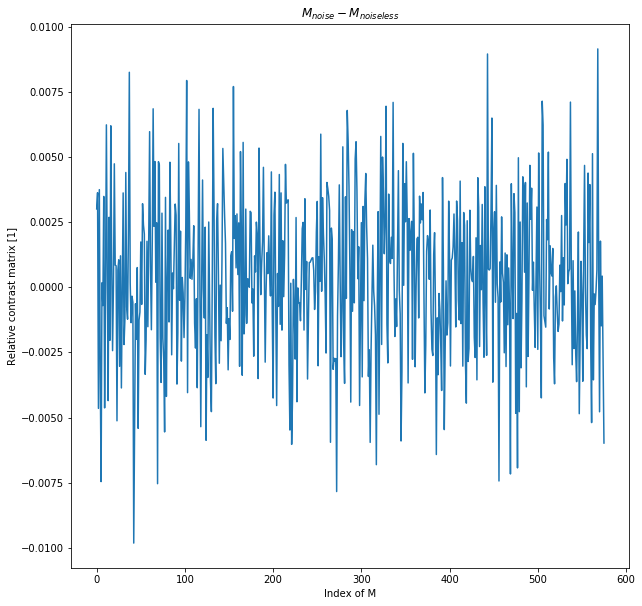

In [253]:
#-------------------------------------------------------------------
# Definiton of noise into the M matrix
#-------------------------------------------------------------------
N_photoncounts = (10**6)/9  #Avg. number of total photocounts divided by the number of gates
#Definition of M matrix with Poisson noise
Mnoisy =-(np.random.poisson(N_photoncounts-N_photoncounts*Mtest2)-np.random.poisson(N_photoncounts))/np.random.poisson(N_photoncounts)
plt.plot(np.arange(0,576,1),Mtest2-Mnoisy) #Plot of the difference between the noiseless matrix and the noisy one
#Labels
plt.xlabel('Index of M')
plt.ylabel('Relative contrast matrix [1]')
plt.title('$M_{noise}-M_{noiseless}$')

Text(0.5, 1.0, '$M_{noise}$')

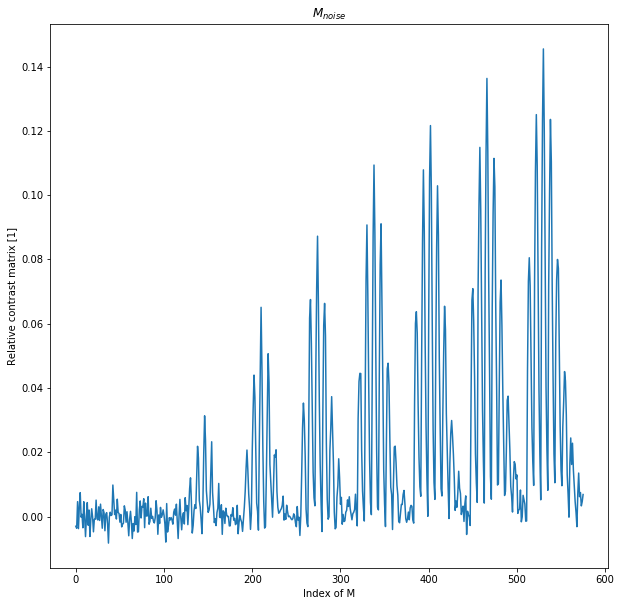

In [254]:
plt.plot(np.arange(0,576,1),Mnoisy)  #Structure of M considering noise
#Labels
plt.xlabel('Index of M')
plt.ylabel('Relative contrast matrix [1]')
plt.title('$M_{noise}$')

## Regularization

In this part we will apply our regularization method using a truncated SVD, for the particular case of the perturbation at 20 cm depth. Nevertheless, this can be modified to see other cases at different depths just by changing the compressed index of A at the initialization section. On the 3D reconstruction we will show the results but for clarity in this part we will just show the procedure for the 20 cm depth case. 

508


Text(0.5, 1.0, 'Log plot of the singular values')

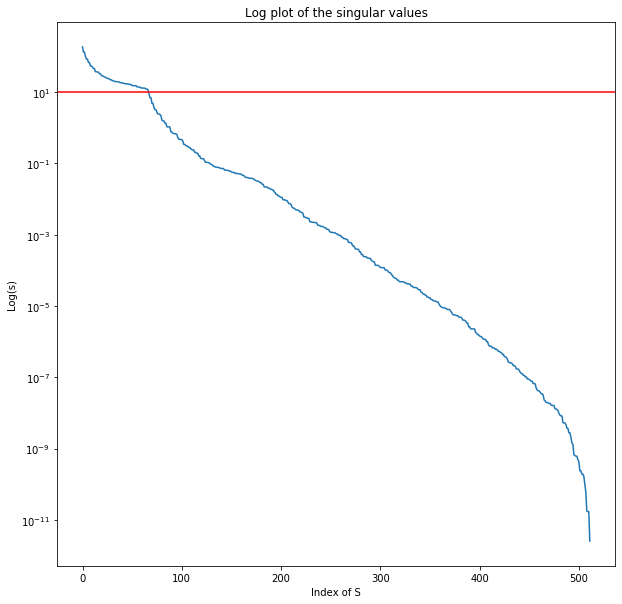

In [255]:
#-------------------------------------------------------------------
# Regularization procedure using SVD
#-------------------------------------------------------------------
#Singular Value Decomposition of W 
u, s, vh = LA.svd(W, full_matrices=False) #This command gives back the svd decomposition of W (s are the singular values, u and vh are the eigenvectors)
r = LA.matrix_rank(W)  #initial rank of W (calculated to know an initial approximation of the cutoff singular value)
print(r)
#Visulalization of the singular values
plt.semilogy(s)
plt.axhline(y=10, color='r', linestyle='-')
#Labels
plt.xlabel('Index of S')
plt.ylabel('Log(s)')
plt.title('Log plot of the singular values')

The rank of the regularized matrix W is 105
The frobenius norm of the singular values for the cutoff is: 1.0211
The perturbation has an index of A matrix: 338


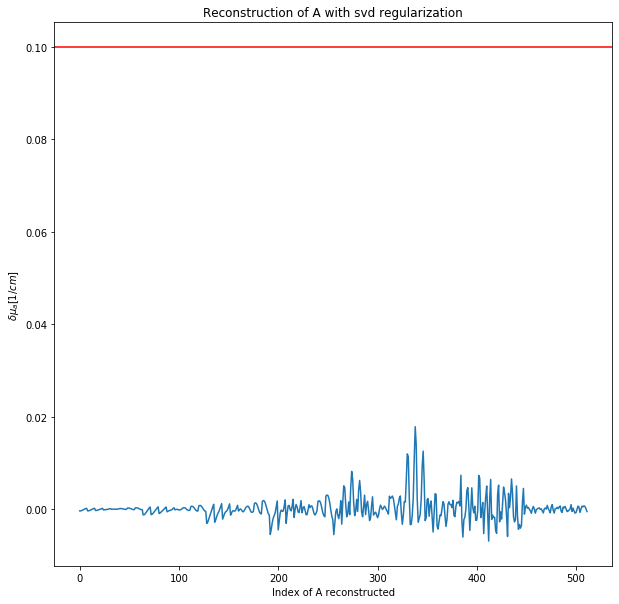

In [256]:
Wnew = u@np.diag(s)@vh #New W matrix with rank reduction (regularized matrix)
# Truncated Svd so that we satisfy the frobenius norm of W truncated vs the intial W. We set our threshold for the error at unity thanks to the log plot of the Singular Values
while LA.norm(Wnew-W,'fro')<1: #fixed to 1 but by increasing the threshold we lost definition of the matrix, and by reducing it we start to get more noise. So our optimal choice is 1.
    s[r:]=0
    Wnew = u@np.diag(s)@vh
    r = r-1
print('The rank of the regularized matrix W is %.0f' %r)
print('The frobenius norm of the singular values for the cutoff is: %.4f' % LA.norm(Wnew-W,'fro'))
# Solution of the inverse (A = Wreg^{-1}*M_noise) problem using the pseudoinverse command implemented in python
Asol = LA.pinv(Wnew)@Mnoisy
plt.axhline(y=0.1, color='r', linestyle='-') #set this line as a graphic help of how our truncation affects the retrieval of the real value of the perturbation (Magnitude)
plt.plot(np.arange(0,512,1),Asol) 
#Labels
plt.xlabel('Index of A reconstructed')
plt.ylabel('$\delta \mu_{a} [1/cm]$')
plt.title('Reconstruction of A with svd regularization')
# Index of the perturbation 
print('The perturbation has an index of A matrix: %.0f' %np.argmax(Asol))

In [257]:
# Command for the interactive plot in 2D of the M matrix with regularized W matrix seen only on jupyter notebooks
# intermap_reconst = interactive(plotting2_noisy,gate = (Nvox_dim*Nvox_dim,Nvox_dim*Nvox_dim*len(t),Nvox_dim*Nvox_dim))
# intermap_reconst

# 3D reconstruction 

## First Perturbation position (10 cm depth)

In [208]:
# Remember to first define W and Mnoisy with the matrix Atest set with index 0, which corresponds to the 10cm depth perturbation
#Singular Value Decomposition of W 
u, s, vh = LA.svd(W, full_matrices=False) #This command gives back the svd decomposition of W (s are the singular values, u and vh are the eigenvectors)
r = LA.matrix_rank(W)  #initial rank of W (calculated to know an initial approximation of the cutoff singular value)

The rank of the regularized matrix W is 105
The frobenius norm of the singular values for the cutoff is: 1.0211
The perturbation has an index of A matrix: 402


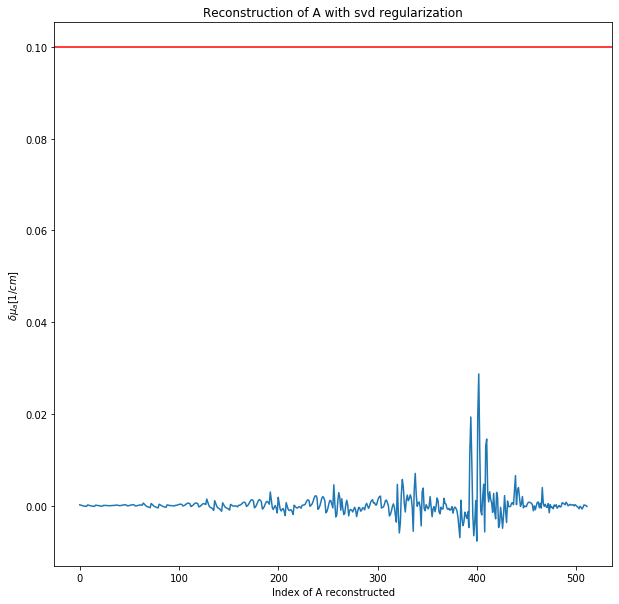

In [209]:
Wnew = u@np.diag(s)@vh #New W matrix with rank reduction (regularized matrix)
# Truncated Svd so that we satisfy the frobenius norm of W truncated vs the intial W. We set our threshold for the error at unity thanks to the log plot of the Singular Values
while LA.norm(Wnew-W,'fro')<1:
    s[r:]=0
    Wnew = u@np.diag(s)@vh
    r = r-1
print('The rank of the regularized matrix W is %.0f' %r)
print('The frobenius norm of the singular values for the cutoff is: %.4f' % LA.norm(Wnew-W,'fro'))
# Solution of the inverse (A = Wreg^{-1}*M_noise) problem using the pseudoinverse command implemented in python
Asol = LA.pinv(Wnew)@Mnoisy
plt.axhline(y=0.1, color='r', linestyle='-') #set this line as a graphic help of how our truncation affects the retrieval of the real value of the perturbation (Magnitude)
plt.plot(np.arange(0,512,1),Asol) 
#Labels
plt.xlabel('Index of A reconstructed')
plt.ylabel('$\delta \mu_{a} [1/cm]$')
plt.title('Reconstruction of A with svd regularization')
# Index of the perturbation 
print('The perturbation has an index of A matrix: %.0f' %np.argmax(Asol))

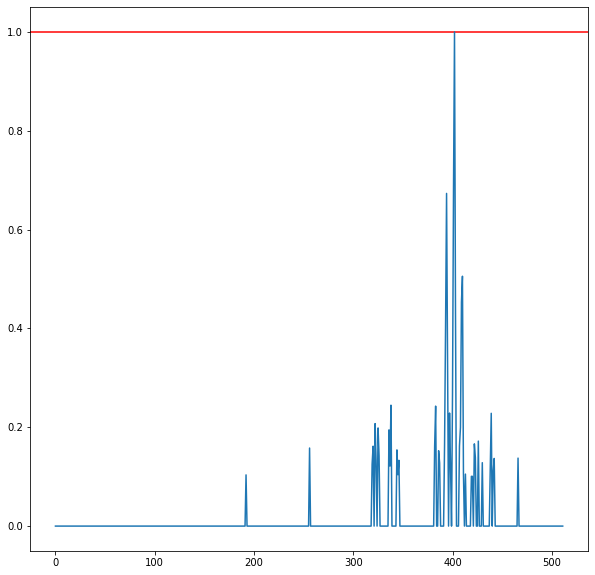

In [210]:
# Normalization of the data for better manipulation
Aabs = np.abs(Asol) #get the absolute value of the data for better manipulation
Amax = np.max(Aabs) #get the max value to apply normatization
Asolvox = Aabs/Amax
# small filtering to avoid a satured 3D image, without loss of generality
Asolvox[Asolvox[:]<0.1]=0
plt.axhline(y=1, color='r', linestyle='-')
plt.plot(np.arange(0,512,1),Asolvox)

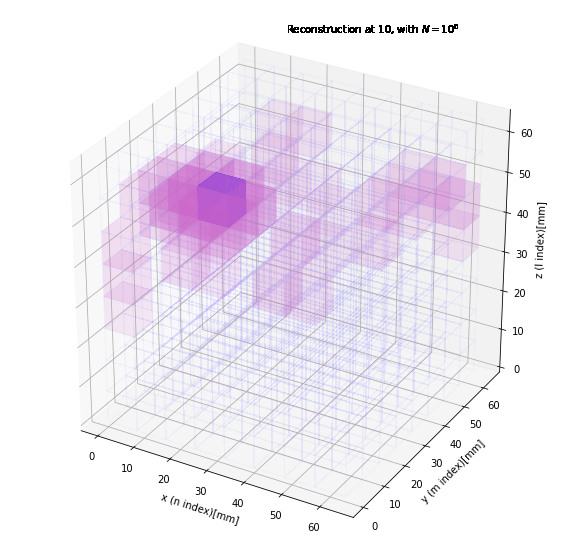

In [212]:
#--------------------------------------------------------------------------------------
#3D representation of absorption perturbation position (A with compressed indices)
#--------------------------------------------------------------------------------------
#plot image size
plt.rcParams['figure.figsize'] = (10,10) 
#create figure
fig = plt.figure()
#specify 3d
ax = fig.gca(projection='3d')
# Make grid
voxels = np.zeros((8, 8, 8)) #size of voxels
#Function to plot our initial reconstruction of A without noise
def matrixArec (voxels,xind,yind,zind,alpha):
    voxels[xind,yind,zind] = True
    x,y,z = np.indices((9,9,9))*8
    ax.voxels(x, y, z, voxels, facecolor = (0.8, 0.4, 0.8, alpha), edgecolor=(0.8, 0.7, 1, 0.01))
    ax.set_xlabel('x (n index)[mm]')
    ax.set_ylabel('y (m index)[mm]')
    ax.set_zlabel('z (l index)[mm]')
    voxels[xind,yind,zind] = False
# Function to plot the reconstruction of A taking into account noise
def matrixArecSol (voxels,xind,yind,zind,alpha, dep):
    voxels[xind,yind,zind] = True
    x,y,z = np.indices((9,9,9))*8
    ax.voxels(x, y, z, voxels, facecolor = (0, 0, 1, alpha), edgecolor=(0.8, 0.7, 1, 0.01))
    ax.set_xlabel('x (n index)[mm]')
    ax.set_ylabel('y (m index)[mm]')
    ax.set_zlabel('z (l index)[mm]')
    ax.text2D(0.5, 0.95, "Reconstruction at %.0f, with $N = 10^{6}$"%dep, transform=ax.transAxes)
    voxels[xind,yind,zind] = False
for l in range(8):
    for n in range(8):
        for m in range(8):
            m_p = m + 8*n + l*64
            # reconstruction of A without noise
            matrixArecSol(voxels,m,n,l,Atest[m_p]*10,10.0)
            # reconstruction of A with noise
            matrixArec(voxels,m,n,l,Asolvox[m_p]/1.8)
# show the overlap of the reconstruction (blue voxel is without noise, the pink ones is with noise)       
plt.show()

## Second Perturbation position (20 cm depth)

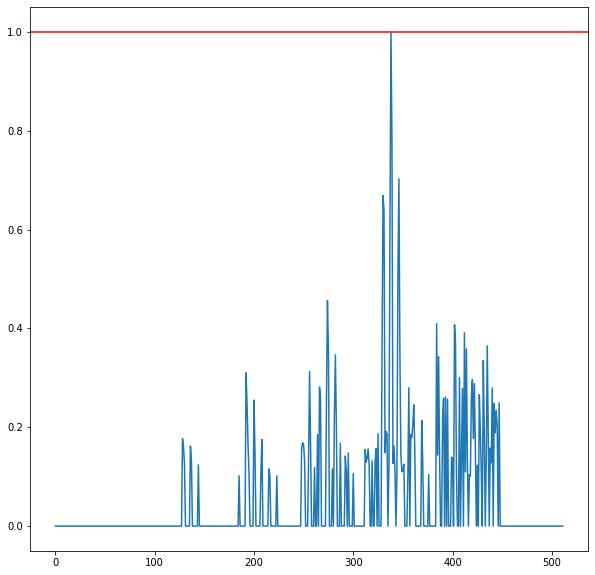

In [258]:
# Remember to first define W and Mnoisy with the matrix Atest set with index 1, which corresponds to the 20cm depth perturbation.
# On this example the initialization code is the one of section 2.1 Inverse problem with noise
# Normalization of the data for better manipulation
Aabs = np.abs(Asol) #get the absolute value of the data for better manipulation
Amax = np.max(Aabs) #get the max value to apply normatization
Asolvox = Aabs/Amax
# small filtering to avoid a satured 3D image, without loss of generality
Asolvox[Asolvox[:]<0.1]=0
plt.axhline(y=1, color='r', linestyle='-')
plt.plot(np.arange(0,512,1),Asolvox)

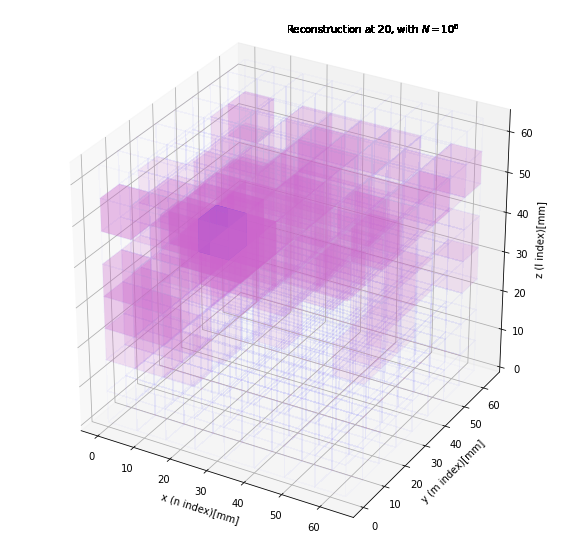

In [259]:
#--------------------------------------------------------------------------------------
#3D representation of absorption perturbation position (A with compressed indices)
#--------------------------------------------------------------------------------------
#plot image size
plt.rcParams['figure.figsize'] = (10,10) 
#create figure
fig = plt.figure()
#specify 3d
ax = fig.gca(projection='3d')
# Make grid
voxels = np.zeros((8, 8, 8)) #size of voxels
for l in range(8):
    for n in range(8):
        for m in range(8):
            m_p = m + 8*n + l*64
            # reconstruction of A without noise
            matrixArecSol(voxels,m,n,l,Atest[m_p]*10,20.0)
            # reconstruction of A with noise
            matrixArec(voxels,m,n,l,Asolvox[m_p]/1.8)
# show the overlap of the reconstruction (blue voxel is without noise, the pink ones is with noise)       
plt.show()

## Third Perturbation position (30 cm depth)

In [242]:
# Remember to first define W and Mnoisy with the matrix Atest set with index 2, which corresponds to the 30cm depth perturbation.
#Singular Value Decomposition of W 
u, s, vh = LA.svd(W, full_matrices=False) #This command gives back the svd decomposition of W (s are the singular values, u and vh are the eigenvectors)
r = LA.matrix_rank(W)  #initial rank of W (calculated to know an initial approximation of the cutoff singular value)

The rank of the regularized matrix W is 105
The frobenius norm of the singular values for the cutoff is: 1.0211
The perturbation has an index of A matrix: 347


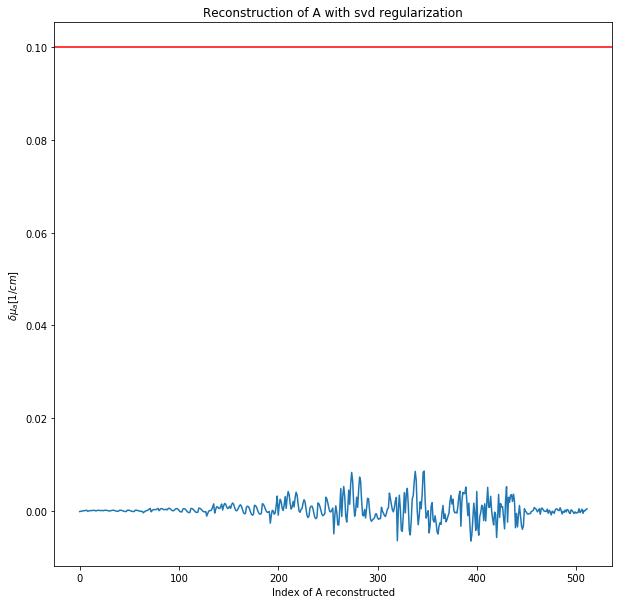

In [243]:
Wnew = u@np.diag(s)@vh #New W matrix with rank reduction (regularized matrix)
# Truncated Svd so that we satisfy the frobenius norm of W truncated vs the intial W. We set our threshold for the error at unity thanks to the log plot of the Singular Values
while LA.norm(Wnew-W,'fro')<1:
    s[r:]=0
    Wnew = u@np.diag(s)@vh
    r = r-1
print('The rank of the regularized matrix W is %.0f' %r)
print('The frobenius norm of the singular values for the cutoff is: %.4f' % LA.norm(Wnew-W,'fro'))
# Solution of the inverse (A = Wreg^{-1}*M_noise) problem using the pseudoinverse command implemented in python
Asol = LA.pinv(Wnew)@Mnoisy
plt.axhline(y=0.1, color='r', linestyle='-') #set this line as a graphic help of how our truncation affects the retrieval of the real value of the perturbation (Magnitude)
plt.plot(np.arange(0,512,1),Asol) 
#Labels
plt.xlabel('Index of A reconstructed')
plt.ylabel('$\delta \mu_{a} [1/cm]$')
plt.title('Reconstruction of A with svd regularization')
# Index of the perturbation 
print('The perturbation has an index of A matrix: %.0f' %np.argmax(Asol))

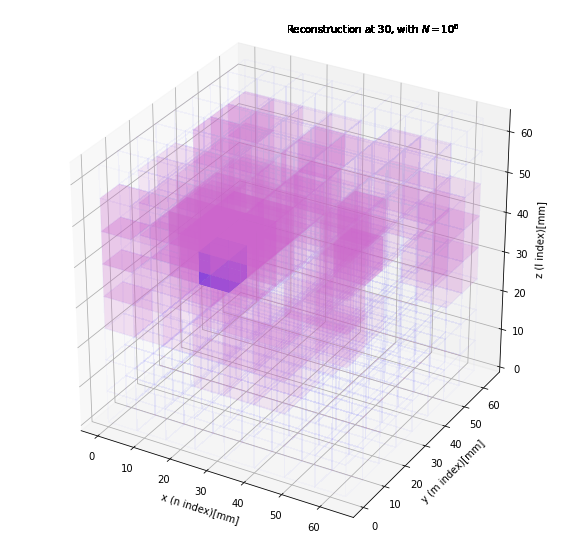

In [244]:
#--------------------------------------------------------------------------------------
#3D representation of absorption perturbation position (A with compressed indices)
#--------------------------------------------------------------------------------------
#plot image size
plt.rcParams['figure.figsize'] = (10,10) 
#create figure
fig = plt.figure()
#specify 3d
ax = fig.gca(projection='3d')
# Make grid
voxels = np.zeros((8, 8, 8)) #size of voxels
for l in range(8):
    for n in range(8):
        for m in range(8):
            m_p = m + 8*n + l*64
            # reconstruction of A without noise
            matrixArecSol(voxels,m,n,l,Atest[m_p]*10,30.0)
            # reconstruction of A with noise
            matrixArec(voxels,m,n,l,Asolvox[m_p]/1.8)
# show the overlap of the reconstruction (blue voxel is without noise, the pink ones is with noise)       
plt.show()

# Appendix: SVD Eigenvectors

## Static plots

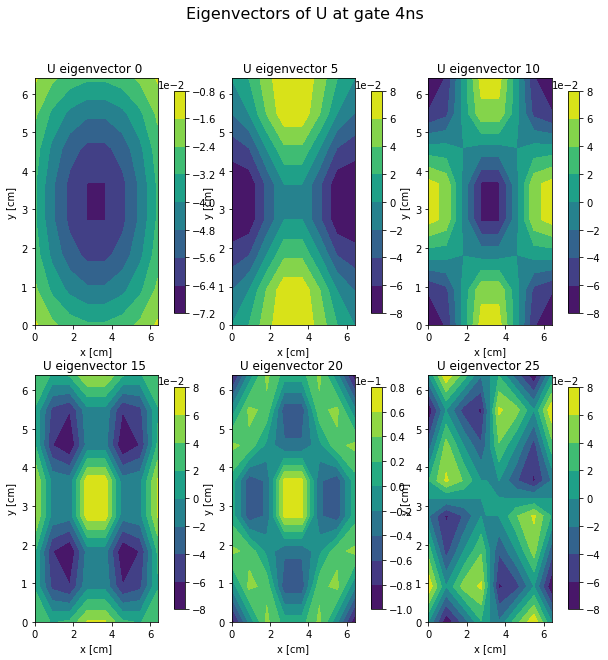

In [247]:
#-----------------------------------------------------------
#Contour plots construction function for U matrix
def plottingUeigv(gate,pert_pos,i,k,evec):
    U_cont = np.zeros((Nvox_dim,Nvox_dim))    # Matrix for contour plot 
    #Reordering of the data of U matrix
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        U_cont[:Nvox_dim,j] = u[counter:counter+Nvox_dim,evec]
        counter = counter + Nvox_dim
        j = j+1
    return uaxs[i,k].contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),U_cont)
#--------------------------------------------------------------------------------------------
fig, uaxs = plt.subplots(2,3) #Creation of a plot with a matrix of 2x3 subplots
fig.suptitle('Eigenvectors of U at gate 4ns', fontsize=16)  # Title format
count = 320 # starting gate (4ns)
eivec = 0
for i in range(2):
    for j in range(3):
        im = plottingUeigv(count,1,i,j,eivec) #calculation of the data for the subplots
        #Subplots formatting
        uaxs[i,j].set_title('U eigenvector %.0f ' % eivec)
        uaxs[i,j].set_xlabel('x [cm]')
        uaxs[i,j].set_ylabel('y [cm]')
        cb = fig.colorbar(im,ax = uaxs[i,j],shrink=0.9, pad = 0.1)
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()
        eivec = eivec + 5

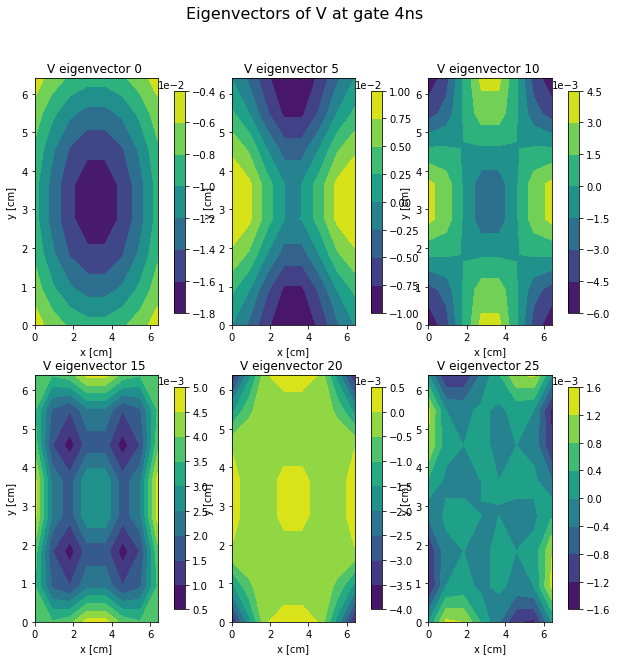

In [248]:
#-----------------------------------------------------------
#Contour plots construction function for V' matrix
def plottingVeigv(gate,pert_pos,i,k,evec):
    V_cont = np.zeros((Nvox_dim,Nvox_dim))    # Matrix for contour plot 
    #Reordering of the data of U matrix
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        V_cont[:Nvox_dim,j] = vh[evec,counter:counter+Nvox_dim]
        counter = counter + Nvox_dim
        j = j+1
    return vaxs[i,k].contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),V_cont)
#--------------------------------------------------------------------------------------------
fig, vaxs = plt.subplots(2,3) #Creation of a plot with a matrix of 2x3 subplots
fig.suptitle('Eigenvectors of V at gate 4ns', fontsize=16)  # Title format
count = 320 # starting gate (4 ns)
eivec = 0
for i in range(2):
    for j in range(3):
        im = plottingVeigv(count,1,i,j,eivec) #calculation of the data for the subplots
        #Subplots formatting
        vaxs[i,j].set_title('V eigenvector %.0f ' % eivec)
        vaxs[i,j].set_xlabel('x [cm]')
        vaxs[i,j].set_ylabel('y [cm]')
        cb = fig.colorbar(im,ax = vaxs[i,j],shrink=0.9, pad = 0.1)
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()
        eivec = eivec + 5

## Interactive jupyter plots code

In [193]:
def plottingUvec(gate,evec):
    U_cont = np.zeros((Nvox_dim,Nvox_dim))    
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        U_cont[:Nvox_dim,j] = u[counter:counter+Nvox_dim,evec]
        counter = counter + Nvox_dim
        j = j+1
    plt.contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),U_cont)
    plt.colorbar()
intermap_Uvec = interactive(plottingUvec,gate = (Nvox_dim*Nvox_dim,Nvox_dim*Nvox_dim*len(t),Nvox_dim*Nvox_dim),evec = (0,511,1))
intermap_Uvec

interactive(children=(IntSlider(value=320, description='gate', max=576, min=64, step=64), IntSlider(value=255,…

In [194]:
def plottingVvec(gate,evec):
    V_cont = np.zeros((Nvox_dim,Nvox_dim))    
    j = 0
    counter = gate-int(Nvox_dim*Nvox_dim)
    while (counter<gate and j<Nvox_dim):
        V_cont[:Nvox_dim,j] = vh[evec,counter:counter+Nvox_dim]
        counter = counter + Nvox_dim
        j = j+1
    plt.contourf(np.linspace(0,6.4,Nvox_dim),np.linspace(0,6.4,Nvox_dim),V_cont)
    plt.colorbar()
intermap_Vvec = interactive(plottingUvec,gate = (64,512,64),evec = (0,511,5))
intermap_Vvec

interactive(children=(IntSlider(value=256, description='gate', max=512, min=64, step=64), IntSlider(value=255,…